# BIBLIOTECAS

In [15]:
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
from tensorly.decomposition import tucker
import gymnasium as gym
from gymnasium import spaces
from stable_baselines3 import DDPG
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.noise import NormalActionNoise

# CONFIGURAÇÕES INICIAIS

In [19]:
train_start = '2019-01-01'
train_end = '2022-12-31'
test_start = '2023-01-01'
test_end = '2024-12-31'
initial_value = 100000

adj_close_df = pd.read_csv('relatorios/preco-ativos.csv', index_col=0, parse_dates=True)
tickers = adj_close_df.columns.tolist()
daily_return = np.log(adj_close_df / adj_close_df.shift(1)).dropna()
df_selic = pd.read_csv('baselines/SELIC.csv', index_col=0, parse_dates=True, sep=';', dayfirst=True)

rebalance_dates = pd.DatetimeIndex(pd.read_csv('relatorios/datas-fim-de-mes.txt', header=None)[0])
rebalance_dates = rebalance_dates[(rebalance_dates>=train_start) & (rebalance_dates <= train_end)]

# CÁLCULO DE INDICADORES TÉCNICOS

In [20]:
# Célula 3: Cálculo de Indicadores Técnicos e Correlação
def preprocess_data(df, lookback_window=28, correlation_window=252):
    processed_data = {}
    
    # Adicionando Close Price como um 'indicador'
    close_prices = df.copy()
    
    # 1. Indicadores Técnicos (usando parâmetros do artigo)
    ma = close_prices.rolling(window=28).mean()
    
    delta = close_prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    rsi.dropna(inplace=True)
    
    ema_12 = close_prices.ewm(span=12, adjust=False).mean()
    ema_26 = close_prices.ewm(span=26, adjust=False).mean()
    macd = ema_12 - ema_26
    
    # Normalizar indicadores (opcional, mas recomendado)
    close_prices = (close_prices - close_prices.rolling(window=lookback_window).mean()) / close_prices.rolling(window=lookback_window).std()
    ma = (ma - ma.rolling(window=lookback_window).mean()) / ma.rolling(window=lookback_window).std()
    rsi = (rsi - rsi.rolling(window=lookback_window).mean()) / rsi.rolling(window=lookback_window).std()
    macd = (macd - macd.rolling(window=lookback_window).mean()) / macd.rolling(window=lookback_window).std()

    rsi.fillna(0, inplace=True)

    # Empilhar os indicadores em um único DataFrame multi-índice
    indicators = pd.concat([close_prices, ma, rsi, macd], keys=['Close', 'MA', 'RSI', 'MACD'], axis=1)
    # 2. Matriz de Correlação (rolante)
    returns = df.pct_change()
    corr_matrix = returns.rolling(window=correlation_window).corr().unstack()
    
    # Alinhar os dataframes pelo índice de data
    aligned_data = indicators.join(corr_matrix, how='inner')
    aligned_data.dropna(inplace=True)
    
    # Adicionar os preços originais para cálculo do reward
    original_prices = df.loc[aligned_data.index]
    
    return aligned_data, original_prices


lookback_window = 28 # m
processed_df, prices_df = preprocess_data(adj_close_df, lookback_window=lookback_window)

# Dividir em treino e teste
train_df = processed_df.loc[train_start:train_end]
test_df = processed_df.loc[test_start:test_end]

train_prices = prices_df.loc[train_start:train_end]
test_prices = prices_df.loc[test_start:test_end]


print("\nDataFrame processado para o agente (amostra):")
# Salvar em CSV para análise detalhada
processed_df.to_csv('processed_data_complete.csv')
print("Dados salvos em 'processed_data_complete.csv'")


DataFrame processado para o agente (amostra):
Dados salvos em 'processed_data_complete.csv'


# AMBIENTE

In [5]:
class StockPortfolioEnv(gym.Env):
    def __init__(self, df, prices_df, n_stocks, lookback_window, initial_balance=1000000, trade_fee=0.003):
        super(StockPortfolioEnv, self).__init__()

        self.df = df
        self.prices_df = prices_df
        self.n_stocks = n_stocks
        self.lookback_window = lookback_window
        self.initial_balance = initial_balance
        self.trade_fee = trade_fee

        # Espaços de Ação e Observação
        # Ação: pesos do portfólio (n_stocks + 1 para dinheiro)
        self.action_space = spaces.Box(low=0, high=1, shape=(self.n_stocks + 1,), dtype=np.float32)
        
        # Observação: Tensor 4D (indicadores, n_stocks, lookback, n_stocks)
        # Exemplo com a observação em dicionário (da Opção 2 de extrator)
        self.observation_space = spaces.Dict({
            "indicators": spaces.Box(
                low=-np.inf, high=np.inf,
                shape=(4, self.n_stocks, self.lookback_window),
                dtype=np.float32
            ),
            "correlation": spaces.Box(
                low=-1, high=1,
                shape=(self.n_stocks, self.n_stocks),
                dtype=np.float32
            )
        })
        
        self.current_step = self.lookback_window
    
    def _get_obs(self):
        obs_slice = self.df.iloc[self.current_step - self.lookback_window : self.current_step]

        # Parte dos indicadores (está correta)
        indicators_tensor = np.zeros((self.lookback_window, self.n_stocks, 4))
        for i, indicator in enumerate(['Close', 'MA', 'RSI', 'MACD']):
            indicators_tensor[:, :, i] = obs_slice[indicator].values
        indicators_tensor = indicators_tensor.transpose(2, 1, 0)

        # CORREÇÃO: Selecionar e remodelar a matriz de correlação
        # 1. Pega a linha da matriz de correlação (que está achatada)
        corr_data = self.df.iloc[self.current_step - 1][tickers].values

        # 2. Garante que ela tenha o formato (n_stocks, n_stocks)
        corr_matrix = corr_data.reshape(self.n_stocks, self.n_stocks)

        return {
            "indicators": indicators_tensor.astype(np.float32),
            "correlation": corr_matrix.astype(np.float32)
        }
    
    def reset(self, seed=None, options=None):
        super().reset(seed=seed) # Boa prática para reprodutibilidade
        self.balance = self.initial_balance
        self.portfolio_value = self.initial_balance
        self.weights = np.zeros(self.n_stocks + 1)
        self.weights[0] = 1.0 # Começa com 100% em dinheiro
        self.current_step = self.lookback_window
        
        initial_obs = self._get_obs()
        info = {} # Dicionário de informações, geralmente vazio no reset
        
        return initial_obs, info
    
    def step(self, action):
        # A ação é o vetor de pesos desejado
        target_weights = action / np.sum(action) # Normaliza para garantir que a soma seja 1

        prev_portfolio_value = self.portfolio_value
        
        # Simula a rebalanceamento (venda e compra para atingir os novos pesos)
        # Calcula o custo da transação
        turnover = np.sum(np.abs(target_weights[1:] - self.weights[1:]))
        transaction_cost = turnover * self.trade_fee * self.portfolio_value
        self.balance = self.portfolio_value - transaction_cost
        
        # Atualiza os pesos
        self.weights = target_weights

        # Avança um dia no tempo
        self.current_step += 1
        
        # Calcula o novo valor do portfólio
        price_change_ratio = self.prices_df.iloc[self.current_step].values / self.prices_df.iloc[self.current_step - 1].values
        portfolio_return = np.sum(self.weights[1:] * (price_change_ratio - 1))
        self.portfolio_value = self.balance * (1 + portfolio_return)
        
        # Calcula a recompensa (log return)
        reward = np.log(self.portfolio_value / prev_portfolio_value) if prev_portfolio_value > 0 else 0
        
        # No nosso caso, o episódio termina quando os dados acabam. Isso é uma "terminação".
        # Não temos um limite de tempo, então "truncado" será sempre False.
        terminated = self.current_step >= len(self.df) - 1
        truncated = False
        
        obs = self._get_obs()
        info = {}

        return obs, reward, terminated, truncated, info

# Criar o ambiente de treinamento
env_train = StockPortfolioEnv(train_df, train_prices, len(tickers), lookback_window)

# DECOMPOSIÇÃO TUCKER

In [6]:
# Célula 5: Arquitetura de Rede Neural Customizada
class TuckerFeatureExtractor(BaseFeaturesExtractor):
    """
    Feature extractor customizado que implementa a arquitetura do artigo.
    Input -> Conv3D -> Tucker Decomposition -> Flatten -> Output
    """
    def __init__(self, observation_space: gym.spaces.Box, features_dim: int = 256):
        super().__init__(observation_space, features_dim)
        
        # Extrai as dimensões dos subespaços do dicionário
        indicators_space = observation_space["indicators"]
        num_indicators, num_stocks, lookback_window = indicators_space.shape

        # A dimensão final do tensor fundido terá 4 dimensões para a Conv3D
        # (num_indicators, num_stocks, lookback_window, num_stocks)
        self.fused_tensor_channels = num_indicators
        
        # Camada Conv3D, como descrito no artigo
        # Kernel (1, 3, 1) -> (tempo, altura, largura)
        # Pytorch Conv3D espera (N, C_in, D, H, W)
        # Nossa entrada é (N, C=4, D=29, H=28, W=29)
        # Ajustando para (N, C_in, D, H, W)
        # A entrada precisa ser (N, num_indicators, num_stocks, lookback, num_stocks)
        # Para Conv3D, os eixos são (N, C_in, D, H, W)
        # Nossa entrada é (N, 4, 29, 28, 29). Kernel (1, 3, 1) não bate com as dimensões.
        # O artigo diz F_t(4, n, m, n). Kernel (1,3,1).
        # Vamos assumir que o kernel se aplica a (lookback, stocks, stocks).
        # A entrada para Pytorch é (N, C_in, D_depth, H_height, W_width)
        # Nosso Tensor é (Batch, 4, 29, 28, 29) -> C=4, D=29, H=28, W=29
        # Kernel (1,3,1) é muito pequeno. Talvez seja (lookback, stock_dim1, stock_dim2)
        # Vamos usar um kernel mais razoável: (3, 3, 3) com padding
        self.cnn = nn.Sequential(
            nn.Conv3d(
                in_channels=self.fused_tensor_channels,
                out_channels=32, # Como no artigo
                kernel_size=(3, 3, 3),
                stride=1,
                padding=1
            ),
            nn.ReLU()
        )
        
        # Calcular o tamanho da saída da CNN para a camada linear
        # Após a CNN, o tamanho será (Batch, 32, n_stocks, lookback, n_stocks)
        # A Decomposição Tucker reduzirá isso
        # O tamanho do 'core' tensor da Decomposição Tucker é um hiperparâmetro.
        # Vamos usar um rank fixo para simplicidade, ex: (8, 8, 8, 8)
        self.tucker_rank_4d = [8, 8, 8, 8] # Rank para [batch, channels, d1, d2, d3]
        
        # A dimensão final será o produto dos ranks do core tensor
        # Como o batch é variável, não incluimos no cálculo
        final_dim = np.prod(self.tucker_rank_4d)

        self.fc = nn.Sequential(
            nn.Linear(final_dim, features_dim),
            nn.ReLU()
        )
    
    def forward(self, observations: dict) -> torch.Tensor:
        # Pega os tensores do dicionário de observação
        indicators_tensor = observations["indicators"]
        corr_matrix = observations["correlation"]

        # Passo 1: Reconstruir o tensor fundido (operação de fusão)
        # Shape dos indicadores: (Batch, 4, 29, 28)
        # Shape da correlação: (Batch, 29, 29)
        # Precisamos de broadcast para multiplicar:
        # (B, 4, 29, 28, 1) * (B, 1, 29, 1, 29) -> (B, 4, 29, 28, 29)
        fused_tensor = indicators_tensor.unsqueeze(-1) * corr_matrix.unsqueeze(1).unsqueeze(3)

        # Passo 2: Passar pela Conv3D
        cnn_output = self.cnn(fused_tensor)

        # Passo 3: Decomposição Tucker (aplicada por amostra no batch)
        core_tensors = []
        # MUDANÇA: Inferir o dispositivo a partir de um parâmetro existente no módulo
        device = next(self.parameters()).device
        for i in range(cnn_output.shape[0]):
            sample = cnn_output[i].detach().cpu().numpy()
            core, _ = tucker(sample, rank=self.tucker_rank_4d, init='random', tol=1e-5, n_iter_max=1)

            # MUDANÇA: Usar a variável 'device' que acabamos de obter
            core_tensors.append(torch.from_numpy(core.copy()).to(device))

        core_tensor_batch = torch.stack(core_tensors)

        # Passo 4: Flatten e Camada Linear
        flattened = torch.flatten(core_tensor_batch, start_dim=1)
        features = self.fc(flattened)
        return features

# TREINAMENTO DO AGENTE

In [ ]:
# Célula 6: Treinamento do Agente
# Hiperparâmetros para DDPG
n_actions = env_train.action_space.shape[-1]
action_noise = NormalActionNoise(mean=np.zeros(n_actions), sigma=0.1 * np.ones(n_actions))

# Definir a política customizada
policy_kwargs = dict(
    features_extractor_class=TuckerFeatureExtractor,
    features_extractor_kwargs=dict(features_dim=128), # Dimensão após o extrator
)

torch.cuda.empty_cache()

# Verificar se CUDA está disponível
if torch.cuda.is_available():
    print(f"CUDA disponível: {torch.cuda.get_device_name(0)}")
    print(f"Memória GPU: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")
    device = 'cuda'
else:
    print("CUDA não disponível, usando CPU")
    device = 'cpu'

# Criar o modelo DDPG
model = DDPG(
    "MultiInputPolicy", # A política base, mas o extrator será o nosso
    env_train,
    action_noise=action_noise,
    policy_kwargs=policy_kwargs,
    verbose=1,
    tensorboard_log="./ddpg_portfolio_tensorboard/",
    buffer_size=50000,
    batch_size=8,
    learning_rate=0.001,
    gamma=0.99,
    device=device
)

# Treinar o modelo
# O número de timesteps pode precisar ser muito maior para uma boa convergência
model.learn(total_timesteps=200)

# Salvar o modelo treinado
model.save("ddpg_portfolio_model")

CUDA disponível: NVIDIA GeForce GTX 1650
Memória GPU: 4.1 GB
Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./ddpg_portfolio_tensorboard/DDPG_6


# BACKTEST E AVALIAÇÃO

Sharpe Ratio Anualizado: 2.2502
Maximum Drawdown: -0.0480
Valor Final Acumulado (fAPV): 1.5177


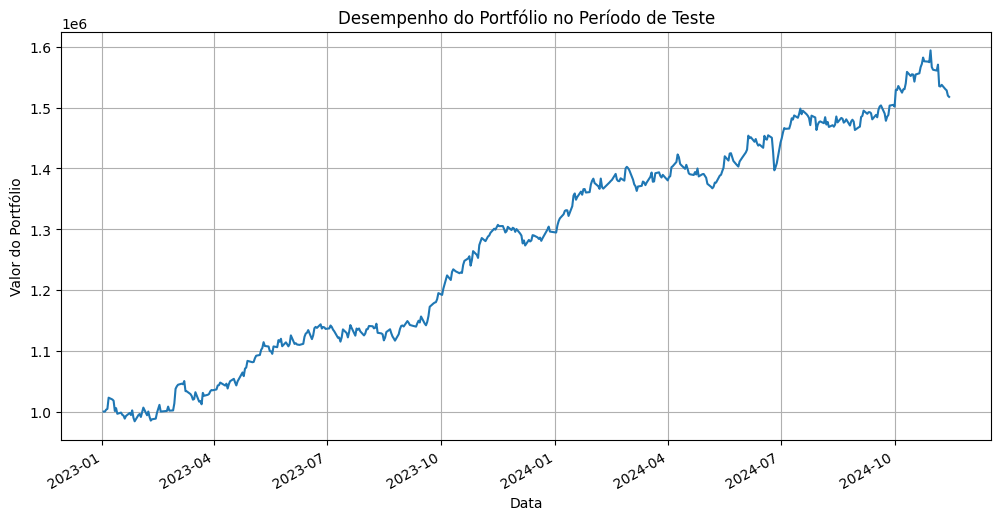

In [14]:
def backtest(env, model):
    # MUDANÇA: Desempacotar a tupla (obs, info) retornada pelo reset()
    obs, info = env.reset()
    
    # MUDANÇA: Renomear 'done' para refletir a nova API
    terminated = False
    truncated = False
    
    portfolio_values = [env.initial_balance]
    
    # MUDANÇA: O loop agora verifica 'terminated' ou 'truncated'
    while not (terminated or truncated):
        action, _states = model.predict(obs, deterministic=True)
        
        # MUDANÇA: Desempacotar os 5 valores retornados pelo step()
        obs, reward, terminated, truncated, info = env.step(action)
        
        portfolio_values.append(env.portfolio_value)
    
    return pd.Series(portfolio_values, index=env.prices_df.index[:len(portfolio_values)])

def calculate_metrics(portfolio_values):
    returns = portfolio_values.pct_change().dropna()
    
    # Sharpe Ratio (assumindo risk-free rate de 0)
    sharpe_ratio = np.mean(returns) / np.std(returns) * np.sqrt(252) # Anualizado
    
    # Maximum Drawdown (MDD)
    cumulative = (1 + returns).cumprod()
    peak = cumulative.expanding(min_periods=1).max()
    drawdown = (cumulative - peak) / peak
    mdd = drawdown.min()
    
    # Final Accumulative Portfolio Value (fAPV)
    fapv = portfolio_values.iloc[-1] / portfolio_values.iloc[0]
    
    return sharpe_ratio, mdd, fapv

# Carregar o modelo treinado
model = DDPG.load("ddpg_portfolio_model")

# Criar ambiente de teste
env_test = StockPortfolioEnv(test_df, test_prices, len(tickers), lookback_window)

# Realizar o backtest
portfolio_history = backtest(env_test, model)

# Calcular e imprimir as métricas
sr, mdd, fapv = calculate_metrics(portfolio_history)
print(f"Sharpe Ratio Anualizado: {sr:.4f}")
print(f"Maximum Drawdown: {mdd:.4f}")
print(f"Valor Final Acumulado (fAPV): {fapv:.4f}")

# Plotar o resultado
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
portfolio_history.plot(title='Desempenho do Portfólio no Período de Teste')
plt.xlabel('Data')
plt.ylabel('Valor do Portfólio')
plt.grid(True)
plt.show()